In [24]:
import pickle
import cv2
from tqdm.auto import tqdm
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
from model import VPTEncoder, VPTCNNEncoder, Controller
from memory import SituationLoader, Memory
from matplotlib import pyplot as plt

from openai_vpt.lib.action_mapping import CameraHierarchicalMapping
from openai_vpt.lib.actions import ActionTransformer
from action_utils import ActionProcessor

from openai_vpt.lib.policy import MinecraftPolicy, VPTCNN
from openai_vpt.lib.tree_util import tree_map

In [25]:
in_model = "data/VPT-models/foundation-model-1x.model"
in_weights = "data/VPT-models/foundation-model-1x-net.weights"
cnn_weights = "data/VPT-models/foundation-model-1x-cnn.weights"

In [26]:
vpt = VPTCNNEncoder(in_model, cnn_weights, freeze=True)
vpt.eval()
expert_dataloader = SituationLoader(vpt, data_dir="data/MakeWaterfallTrain")

In [4]:
demonstrations = expert_dataloader.load_demonstrations(num_demos=1)

Loading expert demonstrations:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
encoded_demos = expert_dataloader.encode_demonstrations(demonstrations)

In [ ]:
situations = expert_dataloader.create_situations(encoded_demos, stride=20, window_size=20,)

In [27]:
situations = expert_dataloader.load_encoded_demos_to_situations(stride=20, window_size=20, num=10, save_dir="data/MakeWaterfallDB-CNNEncoded")

Loading encoded demonstrations:   0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
def _load_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (128, 128), interpolation=cv2.INTER_LINEAR)
        frames.append(frame)
    cap.release()
    return frames

def load_demonstration(demo_id, root_dir="data/MakeWaterfallTrain"):
    video_path = f"{root_dir}/{demo_id}.mp4"
    frames = _load_video(video_path)
    return frames

def load_situation(situation_id, demo_frames):
    situation = demo_frames[situation_id]
    return situation

In [29]:
len(situations)

694

In [30]:
# sanity checking of situations

clean_situations = []

for situation in situations:

    empty = False
    if len(situation['situation_actions']['camera']) < 20 or len(situation['situation_actions']['buttons']) < 20:
        # print("Camera actions empty")
        empty = True

    elif len(situation['next_action']['camera']) != 1 or len(situation['next_action']['buttons']) != 1:
        # print("Next camera action empty")
        empty = True

    if not empty:
        clean_situations.append(situation)

In [31]:
len(clean_situations) - len(situations)

-61

In [43]:
import pickle

with open("data/situations-cnn.pkl", "wb") as f:
    pickle.dump(clean_situations, f)

In [44]:
memory = Memory()

In [35]:
memory.create_index(clean_situations)

In [40]:
def one_hot_encode(actions: list, num_classes: int, add_batch_dim: bool = True):
    '''One-hot encodes the actions'''
    actions = torch.tensor(actions)
    if add_batch_dim:
        actions = actions.unsqueeze(0)
    return torch.nn.functional.one_hot(actions, num_classes=num_classes).float()

def preprocess_situation(situation, device='cuda'):
    # retrieved_situation = torch.Tensor(situation['embedding']).to(device).reshape(1, 1, -1)
    try:
        retrieved_actions = {
            "camera": one_hot_encode(situation['situation_actions']['camera'], 121).to(device),
            "buttons": one_hot_encode(situation['situation_actions']['buttons'], 8641).to(device)
        }
        
        next_action = {
            "camera": one_hot_encode(situation['next_action']['camera'], 121).to(device),
            "buttons": one_hot_encode(situation['next_action']['buttons'], 8641).to(device)
        }
    except:
        print(len(situation['situation_actions']['camera']), len(situation['situation_actions']['buttons']))

    return retrieved_actions, next_action

In [42]:
for situation in tqdm(clean_situations):
    retrieved_actions, next_action = preprocess_situation(situation)

  0%|          | 0/633 [00:00<?, ?it/s]

In [22]:
memory.save_index(save_dir="data", filename="memory_cnn")

In [11]:
memory.load_index('data/memory_cnn.json')

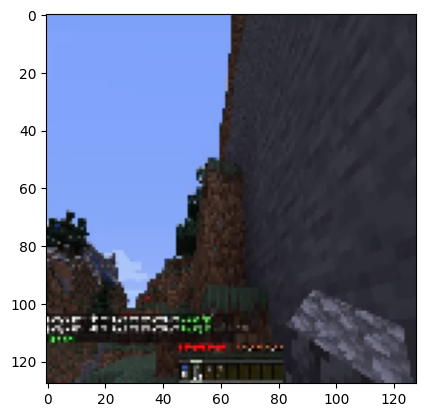

In [10]:
query = vpt(demonstrations[1]['video'][100]).squeeze().cpu().detach().numpy()
plt.imshow(demonstrations[1]['video'][100][..., ::-1])

In [11]:
res = memory.search(query, k=1)

In [12]:
res[0]['distance']

95.3304

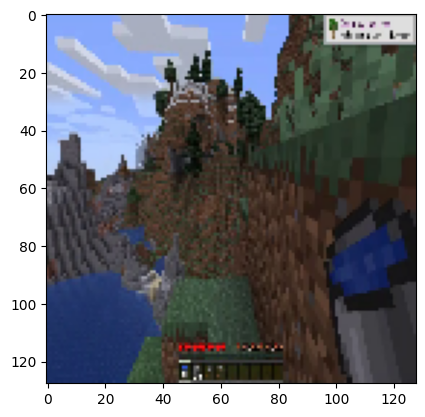

In [15]:
res_demo = load_demonstration(res[0]['demo_id'], root_dir="data/MakeWaterfallDB")
res_situation = load_situation(res[0]['sit_frame_idx'], res_demo)
plt.imshow(res_situation[..., ::-1])

In [ ]:
res[1]['distance']

In [ ]:
Image.fromarray(demonstrations[0]["video"][res[0]["sit_frame_idx"]][..., ::-1])

In [ ]:
Image.fromarray(demonstrations[0]["video"][res[1]["sit_frame_idx"]][..., ::-1])

In [ ]:
controller = Controller()

In [ ]:
def one_hot_encode(actions: list, num_classes: int, add_batch_dim: bool = True):
    '''One-hot encodes the actions'''
    actions = torch.tensor(actions)
    if add_batch_dim:
        actions = actions.unsqueeze(0)
    return torch.nn.functional.one_hot(actions, num_classes=num_classes).float()

In [ ]:
_observation = torch.Tensor(situations[0]["situation"]).reshape(1, 1, -1)
_situation = torch.Tensor(situations[0]["situation"]).reshape(1, 1, -1)
_actions = situations[10]["actions"]
_actions = {
    "camera": one_hot_encode(_actions['camera'], 121),
    "keyboard": one_hot_encode(_actions['buttons'], 8641)
}

In [ ]:
out_key, out_cam = controller(_observation, _situation, _actions)

In [ ]:
out_key.shape

In [ ]:
out_cam.shape